In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def matching(a, b, p):
    if a<0 or b<0:
        return None
    else:
        return a + b - 1.0/p*np.log(np.exp(p*(a)) + np.exp(p*b) - 1)

In [3]:
def next_step(policy, k, d, v, matches = -1, return_matches = False):
    if matches < 0:
        matches = k + matching(d-k, v-k, MATCH_P)
    next_k = (1-GAMMA)*policy*(matches)
    next_d = (1-BETA)*d + BETA_PRIME*(matches)
    next_v = (1- ALPHA)*v + (ALPHA_PRIME+GAMMA_PRIME)*(matches) + (ALPHA - ALPHA_PRIME - GAMMA)*policy*matches
    if return_matches:
        return next_k, next_d, next_v, matches
    else:
        return next_k, next_d, next_v

In [4]:
def plot_m1_z0(k0, d0, v0, num_points = 1000, matches = -1):
    zs = np.zeros(num_points)
    ms = np.zeros(num_points)
    for i in range(num_points):
        zs[i] = 1.0*i/num_points
        k1, d1, v1 = next_step(zs[i], k0, d0, v0, matches = matches)
        ms[i] = k1 + matching(d1-k1, v1-k1, MATCH_P)
    return zs, ms

In [5]:
def find_opt_policy(k0, d0, v0, steps_to_go = 1):
    value = k0 + matching(v0-k0, d0-k0, MATCH_P)
    if steps_to_go == 0:
        return value, []
    else:
        play_0_k, play_0_d, play_0_v = next_step(0, k0, d0, v0)
        future_value_0, future_policy_0 = find_opt_policy(play_0_k, play_0_d, play_0_v, steps_to_go = steps_to_go - 1)
        play_1_k, play_1_d, play_1_v = next_step(1, k0, d0, v0)
        future_value_1, future_policy_1 = find_opt_policy(play_1_k, play_1_d, play_1_v, steps_to_go = steps_to_go - 1)
        if future_value_0 > future_value_1:
            return value+DISCOUNT_FACTOR*future_value_0, [0]+future_policy_0
        else:
            return value+DISCOUNT_FACTOR*future_value_1, [1]+future_policy_1

In [6]:
def myopic_curve(dmax, vmax, num_its = 10000):
    xs = []
    ys = []
    num_each = int(np.floor(np.sqrt(num_its)))
    print('accuracy = ', np.max([dmax,vmax])*1.0/num_each)
    opt_my = np.zeros((num_each, num_each))
    for i in range(num_each):
        d = (i+1)*dmax*1.0/num_each
        threshold = np.exp(-MATCH_P*(1-BETA)*d)
        for j in range(num_each):
            v = (j+1)*vmax*1.0/num_each
            m = matching(d, v, MATCH_P)
            if np.exp(MATCH_P*BETA_PRIME*m)*(np.exp(MATCH_P*m*(GAMMA + ALPHA_PRIME -ALPHA))-1)/(
                np.exp(MATCH_P*m*(1-ALPHA + ALPHA_PRIME))-1) < threshold:
                opt_my[i, j] = 1
    for i in range(num_each-1):
        for j in range(num_each-1):
            if opt_my[i,j] != opt_my[i+1,j] or opt_my[i,j] != opt_my[i,j+1]:
                xs.append((i+1)*dmax*1.0/num_each)
                ys.append((j+1)*vmax*1.0/num_each)
    return xs, ys

In [7]:
def dbar_vbar(dmax, num_its = 10000):
    d = 1.0/num_its
    v = 1.0/num_its
    con_1 = True
    con_0 = True
    con_2 = True
    while d < dmax and con_2:
        if con_0:
            if d >= 1.0/MATCH_P/(1-BETA)*np.log((1-ALPHA + ALPHA_PRIME)/(GAMMA + ALPHA_PRIME -ALPHA)):
                con_0 = False
        elif con_1:
            if d >= 1.0/MATCH_P/(1-BETA)*np.log((
                np.exp(MATCH_P*d*(1-ALPHA + ALPHA_PRIME))-1)/((np.exp(MATCH_P*d*(GAMMA + ALPHA_PRIME -ALPHA))-1)))-BETA_PRIME/(1-BETA)*d:
                con_1 = False
        else:
            v = 1.0/MATCH_P*np.log((np.exp(MATCH_P*d)-1)/(np.exp(MATCH_P*d*(1-BETA/BETA_PRIME))-1))
            if d >= 1.0/MATCH_P*np.log((np.exp(MATCH_P*v)-1)/(np.exp(MATCH_P*v*(1-ALPHA/(ALPHA_PRIME+GAMMA_PRIME)))-1)):
                con_2 = False
        d += dmax*1.0/num_its
    return d, v
        

In [8]:
def plot_arrows(dmax, vmax, amount_d = 10, amount_v = 10, num_steps = 1, sf = 100):
    eps = 0
    X = np.linspace(dmax*0.5/amount_d, dmax*(1-0.5/amount_d), amount_d)
    Y = np.linspace(vmax*0.5/amount_v, vmax*(1-0.5/amount_v), amount_v)
    for v in Y:
        for d in X:
            val, opt = find_opt_policy(0, d, v, steps_to_go = num_steps)
            if opt[0] == 1:
                color = 'b'
                pol = 1
            else:
                color = 'r'
                pol = 0
            k1, d1, v1 = next_step(pol, 0, d, v)
            if color == 'b':
                width = 0.01
            else:
                width = 0.007
            if color == 'r':
                #ax.quiver(d - (d1-d)*eps, v - (v1-v)*eps, 
                #          (d1-d) + (d1-d)*eps, (v1-v) + (v1-v)*eps, color = 'black', scale = sf*np.power((d1-d)**2+(v1-v)**2, .35), 
                #      headwidth=6, headlength=6, headaxislength=6, width = width)
                ax.quiver(d, v, (d1-d), (v1-v), color = color, scale = sf*np.power((d1-d)**2+(v1-v)**2, .35),
                      headwidth=7, headlength=7, headaxislength=7, width = width)
            else:
                ax.quiver(d, v, (d1-d), (v1-v), color = color, scale = sf*np.power((d1-d)**2+(v1-v)**2, .35), 
                      headwidth=3, headlength=3, headaxislength=3, width = width)

# Single-Period Images

In [9]:
MATCH_P     = 10.0
BETA        = 0.05
BETA_PRIME  = 0.2
GAMMA       = 0.06
GAMMA_PRIME = 0.20
ALPHA       = 0.2
ALPHA_PRIME = 0.15
DISCOUNT_FACTOR = 0.6


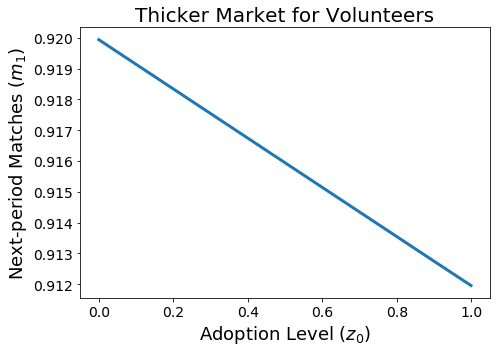

In [10]:
thick = True
fig, ax = plt.subplots(figsize=(7,5))
if thick:
    x,y = plot_m1_z0(0, 1.6, 0.8)
    plt.title('Thicker Market for Volunteers', fontsize = 20)
else:
    x,y = plot_m1_z0(0, 0.8, 0.8)
    plt.title('Thinner Market for Volunteers', fontsize = 20)
plt.plot(x,y, linewidth = 3)
plt.xlabel('Adoption Level $(z_0)$', fontsize = 18)
plt.ylabel('Next-period Matches $(m_1)$', fontsize = 18)
ax.ticklabel_format(useOffset = False)
#ax.set_xticks([0.0, 1.0])
#ax.set_yticks([0.85, 0.855])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout()
plt.show()

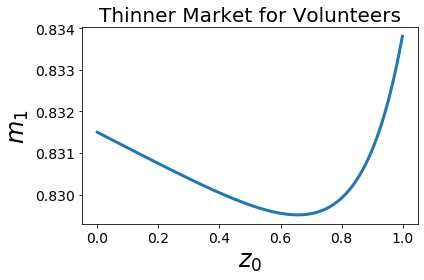

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
x,y = plot_m1_z0(0, 0.8, 0.8)
plt.title('Thinner Market for Volunteers', fontsize = 20)
plt.plot(x,y, linewidth = 3)
plt.xlabel('$z_0$', fontsize = 24)
plt.ylabel('$m_1$', fontsize = 24)
ax.ticklabel_format(useOffset = False)
#ax.set_xticks([0.0, 1.0])
#ax.set_yticks([0.85, 0.855])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout()
plt.show()

# Longer-run

accuracy =  0.002


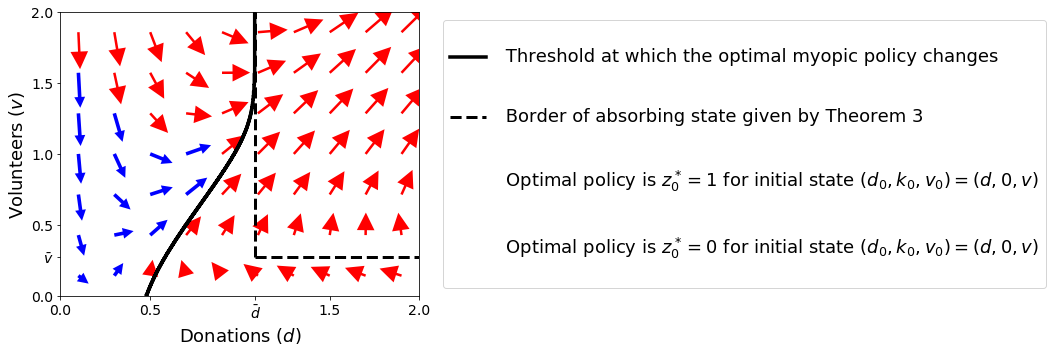

In [12]:
#Generates arrow diagram
#For 

from matplotlib.path import Path
from matplotlib.markers import MarkerStyle



def thicker_arrow_marker(size=10):
    arrow_path = Path([
        (0.0, 0.0),
        (-3.0, -1.5),
        (-3.0, -0.75),
        (-6.0, -0.75),
        (-6.0, 0.75),
        (-3.0, 0.75),
        (-3.0, 1.5),
        (0.0, 0.0)
    ])
    marker = MarkerStyle(marker=arrow_path, fillstyle='full')
    return marker.get_path().transformed(marker.get_transform()).vertices * size

max_d = 2.0
max_v = 2.0
scale = 100

font = {#'family': 'serif',
        'weight': 'normal',
        #'style' : 'italic',
        'size': .18*scale,
        }

fig, ax = plt.subplots(figsize=(15, 5.0))
ax.set(xlim=(0, max_d), ylim=(0, max_v))
plt.xlabel('Donations $(d)$', fontdict = font)
plt.ylabel('Volunteers $(v)$', fontdict = font)
x, y = myopic_curve(max_d, max_v, num_its = 1000000)
dbar, vbar = dbar_vbar(max_d, num_its = 10000)
#ax.quiver(3, 3, 3.2, 3.2, color = 'b', scale = .1,
#                      headwidth=7, headlength=7, headaxislength=7)
ax.scatter(3 ,3, c='w',marker='o',s=500, label='\n Optimal policy is '+r'$z_0^* = 1$'+' for initial state ' + r'$(d_0, k_0, v_0) = (d, 0, v)$' + '\n')
ax.scatter(3 ,3, c='w',marker='o',s=500, label='\n Optimal policy is '+r'$z_0^* = 0$'+' for initial state ' + r'$(d_0, k_0, v_0) = (d, 0, v)$' + '\n' )
plt.plot(x,y, color = 'k', linewidth = .035*scale, label = '\n Threshold at which the optimal myopic policy changes \n')
plt.plot([dbar, max_d], [vbar, vbar], linestyle ='dashed', linewidth = .03*scale, color = 'k', label = '\n Border of absorbing state given by Theorem 3 \n')
plt.plot([dbar, dbar], [vbar, max_v], linestyle ='dashed', linewidth = .03*scale, color = 'k')

#To recreate accuracy of figure in text, set num_steps = 15
plot_arrows(max_d, max_v, amount_d = 10, amount_v = 7, num_steps = 5, sf = .07*scale)
ax.set_xticks([0.0, 0.5,  dbar, 1.5, 2.0])
ax.set_yticks([0.0, vbar, 0.5, 1.0, 1.5, 2.0])
ax.set_xticklabels([0.0, 0.5, r'$\bar{d}$', 1.5, 2.0])
ax.set_yticklabels([0.0, r'$\bar{v}$', 0.5, 1.0, 1.5, 2.0])

ax.tick_params(axis='both', which='major', labelsize=.14*scale)
ax.tick_params(axis='both', which='minor', labelsize=.14*scale)

plt.legend(bbox_to_anchor=(1.04,.5), loc="center left", fontsize = .18*scale, labelspacing = 0.0)
plt.tight_layout()

# Market Death Example

In [13]:
MATCH_P     = 5.0
BETA        = 0.2
BETA_PRIME  = 0.25
GAMMA       = 0.01
GAMMA_PRIME = 0.03
ALPHA       = 0.82
ALPHA_PRIME = 0.9

DISCOUNT_FACTOR = 0.6

In [14]:
policy_list = [0, 1, 0.5]
num_periods = 100
ds = np.zeros((3,100))
ks = np.zeros((3,100))
ms = np.zeros((3,100))
cur_index = 0
for cur_policy in policy_list:
    cur_k, cur_d, cur_v = 0, 1, 1
    for step in range(num_periods):
        ds[cur_index, step] = cur_d
        ks[cur_index, step] = cur_k
        cur_k, cur_d, cur_v, prev_m = next_step(cur_policy, cur_k, cur_d, cur_v, return_matches = True)
        ms[cur_index, step] = prev_m
    cur_index += 1


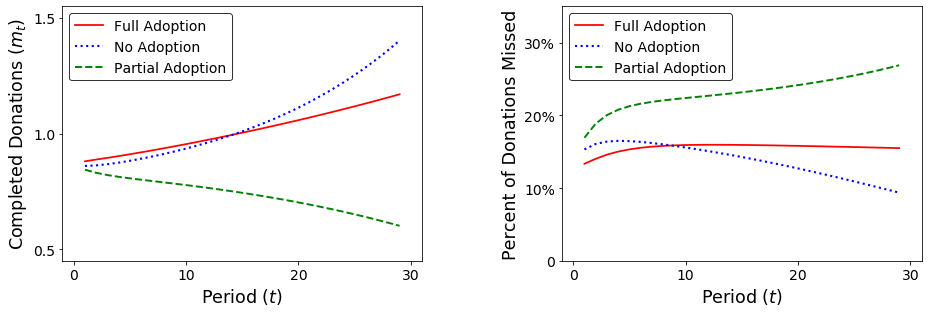

In [15]:
scale = .35
fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize = (13,4.5))
end_amount = 30

ax1.plot(np.arange(1,end_amount),ms[1,1:end_amount], color='red', label='Full Adoption', linewidth = 5*scale)
ax1.plot(np.arange(1,end_amount),ms[0,1:end_amount],color='blue', linestyle = 'dotted', label='No Adoption', linewidth = 6*scale)
ax1.plot(np.arange(1,end_amount),ms[2,1:end_amount],color='green', linestyle = 'dashed', label='Partial Adoption', linewidth = 5.5*scale)
ax1.legend(fontsize = 40*scale, loc = 'upper left', edgecolor = (0,0,0))
ax1.set_xlabel('Period ('+r'$t$'+')', fontsize = 50*scale)
ax1.set_ylabel('Completed Donations ('+r'$m_t$'+')', fontsize = 50*scale)
ax1.set_ylim([0.45, 1.55])
ax1.set_xlim([-1, 31])
ax1.set_xticks([0, 10, 20, 30])
ax1.set_xticklabels([0, 10, 20, 30],Fontsize= 40*scale)
ax1.set_yticks([0.5, 1.0, 1.5])
ax1.set_yticklabels([0.5, 1.0, 1.5],Fontsize= 40*scale)

ax2.plot(np.arange(1,end_amount),(ds[1,1:end_amount]-ms[1,1:end_amount])/ds[1,1:end_amount], color='red', label='Full Adoption', linewidth = 5*scale)
ax2.plot(np.arange(1,end_amount),(ds[0,1:end_amount]-ms[0,1:end_amount])/ds[0,1:end_amount],color='blue', linestyle = 'dotted', label='No Adoption', linewidth = 6*scale)
ax2.plot(np.arange(1,end_amount),(ds[2,1:end_amount]-ms[2,1:end_amount])/ds[2,1:end_amount],color='green', linestyle = 'dashed', label='Partial Adoption', linewidth = 5.5*scale)
ax2.legend(fontsize = 40*scale, loc = 'upper left', edgecolor = (0,0,0))
ax2.set_xlabel('Period ('+r'$t$'+')', fontsize = 50*scale)
ax2.set_ylabel('Percent of Donations Missed', fontsize = 50*scale)
ax2.set_ylim([0, 0.35])
ax2.set_xlim([-1, 31])
ax2.set_xticks([0, 10, 20, 30])
ax2.set_xticklabels([0, 10, 20, 30],Fontsize= 40*scale)
ax2.set_yticks([0, 0.1, 0.2, 0.3])
ax2.set_yticklabels([0, '10%', '20%', '30%'],Fontsize= 40*scale)

plt.tight_layout(w_pad = 8.0)
plt.show()

# Multi-type matching

In [16]:
def n_type_matching(dons, b, ps, step_size = 1e-4):
    #This matching relies on the following:
    #   For each arrival at step t, the probability of a match is 1 - PROD { (1-p[i]/n)^n*dons[i,t] }
    #   The probability of a match of type x is PROB_MATCH * dons[x]/SUM(dons) * ps[x] 
    #   (Why? Because the expected history given no match is approximately the same...
    #       only difference is the prob of selection * prob of match)
    dons = np.array(dons)*1.0
    rem_dons = dons.copy()
    arrival = 0
    while arrival <= b:
        exp_factor = 0
        for i in range(len(rem_dons)):
            exp_factor += 1.0*rem_dons[i]*ps[i]
            if exp_factor == 0:
                print("uhoh")
                exp_factor = 1.0
        match_prob = 1-np.exp(-exp_factor)
        for j in range(len(rem_dons)):
            rem_dons[j] -= match_prob*rem_dons[j]*ps[j]/exp_factor*step_size
        arrival += step_size
    matches = np.zeros(len(dons))
    for i in range(len(matches)):
        matches[i] = dons[i] - rem_dons[i]
    return matches
    

In [17]:
def n_type_matching_sim(dons, b, ps, n = 100, seed = 0):
    np.random.seed(seed)
    for i in range(len(dons)):
        dons[i] *= n
    matches = np.zeros(len(dons))
    for i in range(b*n):
        seeking_match = True
        for j in range(int(np.sum(dons))):
            if seeking_match:
                cur_type = find_type(dons, np.random.rand())
                #print(cur_type, ps)
                if np.random.rand() < ps[cur_type]/n:
                    dons[cur_type] -= 1
                    matches[cur_type] += 1
                    seeking_match = False
    return matches/n
            
            
            
def find_type(vec, prob):
    if np.sum(vec) == 0:
        return 0
    vec /= np.sum(vec)
    ind = 1
    prob_sum = vec[0]
    while prob_sum < prob:
        prob_sum += vec[ind]
        ind += 1
    #print(vec, prob, ind)
    return ind - 1
    


In [18]:
MATCH_PS = np.array([1.0,1.0])

def n_type_next_step(policy, k, d, v, probs, matches = [-1], return_matches = False, ss = 1e-4):
    #assumes we get numpy arrays as inputs
    if np.sum(matches) < 0:
        matches = k + n_type_matching(d-k, v-np.sum(k), probs, step_size = ss)
    next_k = (1-GAMMA)*policy*(matches)
    next_d = (1-BETA)*d + BETA_PRIME*(matches)
    next_v = (1- ALPHA)*v + (ALPHA_PRIME+GAMMA_PRIME)*(np.sum(matches)) + (ALPHA - ALPHA_PRIME - GAMMA)*np.sum(policy*matches)
    if return_matches:
        return next_k, next_d, next_v, matches
    return next_k, next_d, next_v

In [19]:
def grid_search_z0(k0, d0, v0, probs = MATCH_PS, total_num_points = 1000):
    #assumes we get numpy arrays as inputs
    matches = k0 + n_type_matching(d0-k0, v0-np.sum(k0), probs)
    dim1 = len(d0)
    dim2 = int(np.power(total_num_points, 1/dim1))
    zs = np.zeros((np.power(dim2+1, dim1), dim1))
    ms = np.zeros(np.power(dim2+1, dim1))
    for i in range(len(zs)):
        cur_zs = np.zeros(dim1)
        for j in range(dim1):
            cur_zs[j] = (int(i/np.power(dim2+1,j))%(dim2+1))*1.0/dim2
        zs[i,:] = cur_zs
        k1, d1, v1 = n_type_next_step(cur_zs, k0, d0, v0, probs = probs, matches = matches)
        ms[i] = np.sum(k1 + n_type_matching(d1-k1, v1-np.sum(k1), probs))
    return zs, ms

In [20]:
#O(num_mps^2*search_space)
def generate_2d_opts(start_val, end_val, num_mps = 11, search_space = 100, offset = 0):
    st = time.time()
    opts = np.zeros((num_mps, num_mps))
    if num_mps == 1:
        mps = np.ones(1)
        mps[0] = start_val
    else:
        mps = (np.arange(num_mps))*(end_val-start_val)/(num_mps-1)+start_val

    for i1 in range(len(mps)):
        for i2 in range(i1, len(mps)):
            p1 = mps[i1]
            p2 = mps[i2] + offset
            MATCH_PS = np.array([p1,p2])
            x,y = grid_search_z0(init_ks, init_ds, init_vs, probs = MATCH_PS, total_num_points = search_space)
            cur_opt = x[np.argmax(y)]
            #print(p1, p2, cur_opt)
            if cur_opt[1] == 1:
                if cur_opt[0] == 1:
                    opts[i1,i2] = 1
                else:
                    print("hmm")
            elif cur_opt[1] == 0:
                if cur_opt[0] == 1:
                    opts[i1,i2] = 0.5
                elif cur_opt[0] == 0:
                    opts[i1,i2] = 0.0
                else:
                    print("hmmm2")
            else:
                print('hmmm3')
    for i1 in range(len(mps)-1):
        for i2 in range(i1+1, len(mps)):
            opts[i2,i1] = opts[i1,i2]
    print(time.time()-st)
    return mps, opts


In [21]:
def plot_2d_opts(mps, opts, subsample = 1):
    #1 is all adoption
    #0.5 is only the low-prob adoption
    #0 is no adoption
    if subsample > 1:
        old_mps = mps.copy()
        old_opts = opts.copy()
        newdim = int(len(mps)/subsample)
        mps = np.zeros(newdim)
        opts = np.zeros((newdim,newdim))
        for i in range(newdim):
            mps[i] = old_mps[subsample*i]
            for j in range(newdim):
                opts[i,j] = old_opts[subsample*i,subsample*j]

    matrix = opts
    num_mps = len(mps)
    start_val = mps[0]
    end_val = mps[-1]

    # Create a color map for the values in the matrix
    cmap = plt.cm.get_cmap('brg')

    # Create a figure and axis object
    fig, ax = plt.subplots()

    wid = (end_val-start_val)/(num_mps-1)

    # Create a grid of squares from the matrix
    for i in range(matrix.shape[0]):
        for j in range(i+1):
            if i >= j:
                color = cmap(matrix[i,j])
                if matrix[i,j] == 0:
                    rect = plt.Rectangle((mps[j], mps[i]), wid, wid, fc = 'none', hatch = '---', ec=color, linewidth = 0.0)
                elif matrix[i,j] == 1:
                    rect = plt.Rectangle((mps[j], mps[i]), wid, wid,  fc = 'none', hatch = '|||', ec=color, linewidth = 0.0)

                else:
                    rect = plt.Rectangle((mps[j], mps[i]), wid, wid, fill=True, color=color)
                ax.add_patch(rect)

    # Set the x and y limits of the axis to show the entire grid
    ax.set_xlim([start_val, end_val+wid])
    ax.set_ylim([start_val, end_val+wid])

    # Create a colorbar to show the color scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    plt.colorbar(sm, ax=ax)
    plt.xlim([5,15])
    plt.ylim([5,15])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    # Show the plot
    plt.show()

In [22]:
# SETTING 1: Market Death
#0/1 optimality holds even for a large search_space

MATCH_P     = 5.0
BETA        = 0.11
BETA_PRIME  = 0.12
GAMMA       = 0.04
GAMMA_PRIME = 0.07
ALPHA       = 0.35
ALPHA_PRIME = 0.39

init_ks = np.array([0.0,0.0])
init_ds = np.array([0.5,0.5])
init_vs = 1.0


In [23]:
#set num_mps to 401 to recover higher-resolution figure
set1mps, set1opts = generate_2d_opts(5, 15, num_mps = 6, search_space = 1)

4.097683906555176


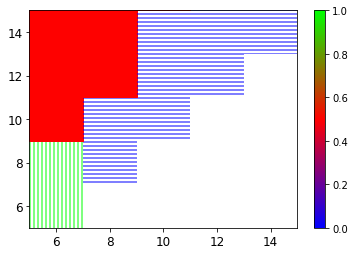

In [24]:
plot_2d_opts(set1mps, set1opts, subsample = 1)

In [25]:
# SETTING 2: illustration of all-or-nothing policy for thin market
#0/1 optimality holds even for a large search_space

MATCH_P     = 10.0
BETA        = 0.05
BETA_PRIME  = 0.2
GAMMA       = 0.06
GAMMA_PRIME = 0.20
ALPHA       = 0.2
ALPHA_PRIME = 0.15

init_ks = np.array([0.0,0.0])
init_ds = np.array([0.4,0.4])
init_vs = 0.8

In [26]:
#set num_mps to 401 to recover higher-resolution figure
set2mps, set2opts = generate_2d_opts(5, 15, num_mps = 6, search_space = 1)

3.674682378768921


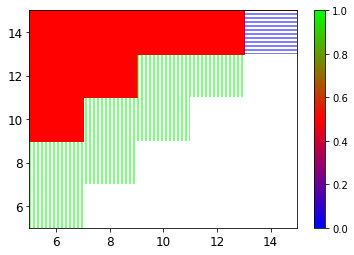

In [27]:
plot_2d_opts(set2mps, set2opts, subsample = 1)

In [28]:
# SETTING 3: illustration of all-or-nothing policy for thin market
#0/1 optimality holds even for a large search_space

MATCH_P     = 10.0
BETA        = 0.05
BETA_PRIME  = 0.2
GAMMA       = 0.04
GAMMA_PRIME = 0.20
ALPHA       = 0.2
ALPHA_PRIME = 0.15

init_ks = np.array([0.0,0.0])
init_ds = np.array([0.4,0.4])
init_vs = 0.8

In [29]:
#set num_mps to 401 to recover higher-resolution figure
set25mps, set25opts = generate_2d_opts(5, 15, num_mps = 6, search_space = 1)

3.6395113468170166


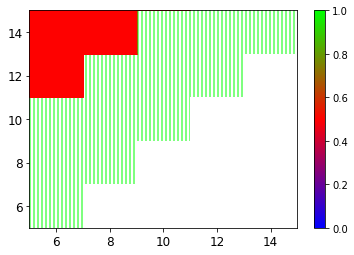

In [30]:
plot_2d_opts(set25mps, set25opts, subsample = 1)

# Simulations for Heterogeneous Donors

In [31]:
def find_opt_long_run_policy(num_periods, policy_space, k_0, ds_0, v_0, probs, ss = 1e-4):
    if num_periods <= 0:
        total_m = np.sum(n_type_matching(ds_0 - k_0, v_0 - np.sum(k_0), probs, step_size = ss)) + np.sum(k_0)
        return [], total_m
    best_val = 0
    best_future_policy = []
    best_cur_policy = -1
    for i in policy_space:
        cur_k, cur_ds, cur_v, prev_m = n_type_next_step(i, k_0, ds_0, v_0, probs, return_matches = True, ss = ss)
        prev_m_total = np.sum(prev_m)
        future_pol, future_val = find_opt_long_run_policy(num_periods-1, policy_space, 
                                                              cur_k, cur_ds, cur_v, probs, ss = ss)
        if future_val*DISCOUNT_RATE + prev_m_total > best_val:
            best_val = future_val*DISCOUNT_RATE + prev_m_total
            best_future_policy = future_pol
            best_cur_policy = i
    best_future_policy.insert(0, best_cur_policy)
    return best_future_policy, best_val
        
    

In [32]:
def play_myopic(num_periods, k_0, ds_0, v_0, probs, ss = 1e-4, 
                pols = [np.array([0,0]),np.array([1,0]),np.array([1,1]), np.array([0,1])], margin = 0):
    next_policy, orig_m, opt_m = myopic_opt(k_0, ds_0, v_0, probs, ss = ss, pols = pols, margin = margin)
    #next_policy = np.array([0,0])
    cur_k, cur_ds, cur_v = n_type_next_step(next_policy, k_0, ds_0, v_0, probs, matches = orig_m, ss = ss)
    prev_m_total = np.sum(orig_m)
    if num_periods <= 1:
        future_val = np.sum(opt_m)
        future_policy = []
    else:
        future_policy, future_val = play_myopic(num_periods-1, cur_k, cur_ds, cur_v, probs, 
                                                ss = ss, pols = pols, margin = margin)
    cur_val = future_val*DISCOUNT_RATE + prev_m_total
    future_policy.insert(0,next_policy)
    return future_policy, cur_val

In [33]:
def myopic_opt(k_0, ds_0, v_0, probs, ss = 1e-4, 
               pols = [np.array([0,0]),np.array([1,0]),np.array([1,1]), np.array([0,1])], margin = 0):
    best_pol = np.array([-1,-1])
    best_m1 = -1
    curm = -1
    for cur_pol in pols:
        k1, ds1, v1, m0 = n_type_next_step(cur_pol, k_0, ds_0, v_0, probs, matches = curm, return_matches = True, ss = ss)
        m1 = n_type_matching(ds1-k1, v1-np.sum(k1), probs, step_size = ss) + k1
        total_m1 = np.sum(m1)
        #print(cur_pol, total_m1, np.sum(best_m1) + margin, margin)
        if total_m1 > np.sum(best_m1) + margin:
            best_pol = cur_pol
            best_m1 = m1
        curm = m0
    return best_pol, m0, best_m1
        

In [34]:
def policy_perf(z1s, z2, k_0, ds_0, v_0, probs, m0 = -1,  ss = 1e-4, switch = False):
    ms = np.zeros(len(z1s))
    for i in range(len(z1s)):
        z1 = z1s[i]
        if switch:
            cur_pol = np.array([z2,z1])
        else:
            cur_pol = np.array([z1,z2])
        k1, ds1, v1, m0 = n_type_next_step(cur_pol, k_0, ds_0, v_0, probs, matches = m0, return_matches = True, ss = ss)
        m1 = n_type_matching(ds1-k1, v1-np.sum(k1), probs, step_size = ss) + k1
        ms[i] = np.sum(m1)*DISCOUNT_RATE + np.sum(m0)
    return z1s, ms

In [35]:
def gap_myopic_opt(num_periods, k_0, ds_0, v_0, probs, ss = 1e-4, return_all_info = False):
    st = time.time()
    opt_pol, opt_val = find_opt_long_run_policy(num_periods, 
                                                [np.array([0,0]),np.array([1,0]),np.array([1,1])], 
                                                #[np.array([0,0]),np.array([1,0]),np.array([0,1]),np.array([1,1])], 
                                                k_0, ds_0, v_0, probs, ss = ss)
    #print(time.time() - st)
    my_pol, my_val = play_myopic(num_periods, k_0, ds_0, v_0, probs, ss = ss)
    first_m = np.sum(n_type_matching(ds_0 - k_0, v_0 - np.sum(k_0), probs, step_size = ss)) + np.sum(k_0)
    my_val -= first_m
    opt_val -= first_m
    #print(k_0, ds_0, v_0, probs, my_pol,my_val)
    #print(time.time() - st)
    if return_all_info:
        my_pols = np.zeros(4)
        opt_pols = np.zeros(4)
        for j in range(num_periods):
            my_pols[int(my_pol[j][0]*2 + my_pol[j][1])] += 1
            opt_pols[int(opt_pol[j][0]*2 + opt_pol[j][1])] += 1
        return my_val/opt_val, my_pols, opt_pols
    else:
        return my_val/opt_val
    

In [36]:
def check_0_1(num_periods, k_0, ds_0, v_0, probs, ss = 1e-4, num_mistakes_allowed = 0):
    pol_opts = [np.array([0,0]),np.array([1,0]),np.array([0,1]),np.array([1,1]), 
               np.array([0.1,0]),np.array([0.9,0]),np.array([0.1,1]),np.array([0.9,1]),
               np.array([0,0.1]),np.array([1,0.1]),np.array([0,0.9]),np.array([1,0.9]),
               np.array([0.1,0.1]),np.array([0.9,0.1]),np.array([0.1,0.9]),np.array([0.9,0.9])]
    num_non_extreme = 0
    ans, val = find_opt_long_run_policy(num_periods, pol_opts, k_0, ds_0, v_0, probs, ss = ss)
    print(ans, val)
    for i in ans:
        num_non_extreme += 1
        if i[0] == 0 and i[1] == 0:
            num_non_extreme -= 1
        elif i[0] == 1 and (i[1] == 0 or i[1] == 1):
            num_non_extreme -= 1
        #if (i != np.array([0,0]) or i != np.array([1,0]) or i != np.array([1,1])):
    if num_non_extreme > num_mistakes_allowed:
        return False
    else:
        return True

In [37]:
def check_0_1_myop(num_periods, k_0, ds_0, v_0, probs, ss = 1e-4, num_mistakes_allowed = 0, margin = 0, printing = False):
    pol_opts = [np.array([0,0]),np.array([1,0]),np.array([1,1]),np.array([0,1]), 
               np.array([0.2,0]),np.array([0.8,0]),np.array([0.2,1]),np.array([0.8,1]),
               np.array([0,0.2]),np.array([1,0.2]),np.array([0,0.9]),np.array([1,0.8]),
               np.array([0.2,0.2]),np.array([0.8,0.2]),np.array([0.2,0.8]),np.array([0.8,0.8])]
    num_non_extreme = 0
    ans, val = play_myopic(num_periods, k_0, ds_0, v_0, probs, ss = ss, pols = pol_opts, margin = margin)
    #print(ans, val)
    for i in ans:
        num_non_extreme += 1
        if i[0] == 0 and i[1] == 0:
            num_non_extreme -= 1
        elif i[0] == 1 and (i[1] == 0 or i[1] == 1):
            num_non_extreme -= 1
        #if (i != np.array([0,0]) or i != np.array([1,0]) or i != np.array([1,1])):
    if num_non_extreme > num_mistakes_allowed:
        if printing:
            print(ans)
        return False
    else:
        return True

In [38]:
kinit = 0
vinit = 1
dh = 0.5
de = 0.5
BETA = .05
BETA_PRIME = .1
ALPHA = .1
MATCH_P_H = 2
MATCH_P_E = 8
GAMMA = .05
GAMMA_PRIME = .1
ALPHA_PRIME = .1

MATCH_PS = np.array([MATCH_P_H, MATCH_P_E])
dinit = np.array([dh, de])
DISCOUNT_RATE = 1

In [39]:
#To recreate simulations from paper, set num_trials = 1000
#This takes around 30 seconds per simulation

num_trials = 10
num_steps = 5
acc =1e-4


st = time.time()
ratios = np.zeros((2,num_trials))
good_sims = 0
exacts = [0,0]
total_myops = np.zeros((2,4))
total_opts = np.zeros((2,4))
avg_discount = 0

np.random.seed(0)

for i in range(num_trials):
    vals = np.random.rand(18)
    dh = vals[0]*1.0
    de = vals[1]*1.0
    BETA = vals[2]*.1
    BETA_PRIME = vals[3]*.1 + BETA
    ALPHA = vals[4]*.2
    MATCH_P_H = vals[6]*5
    MATCH_P_E = (vals[7] + 1)*MATCH_P_H
    GAMMA = vals[8]*.1
    GAMMA_PRIME = vals[10]*.1 + GAMMA
    ALPHA_PRIME = vals[14]*0.2
    

    max_growth_rate = np.max([ALPHA_PRIME - ALPHA + GAMMA_PRIME, GAMMA_PRIME - GAMMA, BETA_PRIME - BETA])
    DISCOUNT_RATE = 0.7 + (0.3-max_growth_rate)*vals[15]
    avg_discount += DISCOUNT_RATE/num_trials

    kinit = 0
    vinit = 1.0
    MATCH_PS = np.array([MATCH_P_H, MATCH_P_E])
    dinit = np.array([dh, de])
    
    cur_ans, myop_zs, opt_zs = gap_myopic_opt(num_steps, kinit, dinit, vinit, MATCH_PS, ss = acc, return_all_info = True)
    ratios[0, i] = cur_ans
    if cur_ans == 1:
        exacts[0] += 1
    total_myops[0,:] += myop_zs
    total_opts[0,:] += opt_zs
    if (GAMMA - ALPHA + ALPHA_PRIME) < 0:
        good_sims += 1
        ratios[1, i] = cur_ans
        if cur_ans == 1:
            exacts[1] += 1
        total_myops[1,:] += myop_zs
        total_opts[1,:] += opt_zs
print(time.time()-st)

292.09793734550476


In [40]:
good_sims, exacts, np.round(np.min(ratios[0]),3), np.round(np.mean(ratios[0]),3)

(1, [8, 1], 0.997, 1.0)

In [41]:
incorrects_dons = []
for i in range(num_trials):
    if ratios[0,i] < 1:
        incorrects_dons.append(ratios[0,i])

# Simulations for Heterogeneous Volunteers

In [42]:
#Policy is what fraction of tasks are AVAILABLE for adoption
#Subscript s is students (generally prefer one-time sign-ups)
#Subscript p is professionals (generally prefer adoption)

def next_step_two_types(policy, k_s, k_p, d, v_s, v_p, return_matches = False):
    spot_amount = matching(d - k_s - k_p, v_s + v_p - k_s - k_p, MATCH_P)
    if spot_amount == None:
        print(d, k_s, k_p)
    matches = k_s + k_p + spot_amount
    matches_s = k_s + (v_s - k_s)/(v_s + v_p - k_s - k_p)*spot_amount
    matches_p = matches - matches_s
    next_k_s = (1-S_GAMMA)*(k_s + policy*(matches_s - k_s)*Q_STUS)
    next_k_p = (1-P_GAMMA)*(k_p + policy*(matches_p - k_p)*Q_PROS)
    next_d = (1-BETA)*d + BETA_PRIME*(matches)
    next_v_s = ((1-S_ALPHA)*(v_s) + (S_ALPHA_PRIME + S_GAMMA_PRIME)*matches_s + 
               (S_ALPHA - S_ALPHA_PRIME - S_GAMMA)*(k_s + Q_STUS*policy*(matches_s - k_s)))
    #temp = (1-S_ALPHA)*(v_s) + (S_ALPHA_PRIME + S_GAMMA_PRIME)*matches_s + (-S_GAMMA + S_ALPHA -S_ALPHA_PRIME)*policy*(matches_s)*Q_STUS
    next_v_p = ((1- P_ALPHA)*v_p + (P_ALPHA_PRIME+P_GAMMA_PRIME)*(matches_p)+ 
               (P_ALPHA - P_ALPHA_PRIME - P_GAMMA)*(k_p + Q_PROS*policy*(matches_p - k_p)))
    if return_matches:
        next_matches = matching(next_d - next_k_s - next_k_p, next_v_s + next_v_p - next_k_s - next_k_p, MATCH_P) + next_k_s + next_k_p
        return next_k_s, next_k_p, next_d, next_v_s, next_v_p, next_matches
    else:
        return next_k_s, next_k_p, next_d, next_v_s, next_v_p
    
    
def myopic_opt(k_s, k_p, d, v_s, v_p):
    state_0 = next_step_two_types(0, k_s, k_p, d, v_s, v_p)
    state_1 = next_step_two_types(1, k_s, k_p, d, v_s, v_p)
    fixed_0 = state_0[0] + state_0[1]
    m_if_0 =  fixed_0 + matching(state_0[2] - fixed_0, state_0[3] + state_0[4] - fixed_0, MATCH_P)
    fixed_1 = state_1[0] + state_1[1]
    m_if_1 =  fixed_1 + matching(state_1[2] - fixed_1, state_1[3] + state_1[4] - fixed_1, MATCH_P)
    if m_if_0 > m_if_1:
        return 0
    else:
        return 1

In [43]:
def multi_period_matches_two_types(policies, k_s0, k_p0, d0, v_s0, v_p0):
    total_discounted_matches = 0
    cur_discount = 1
    
    cur_ks, cur_kp, cur_d, cur_vs, cur_vp = k_s0, k_p0, d0, v_s0, v_p0

    #matches reported will be for periods 1 to len(policies) = T
    for i in range(len(policies)):
        cur_ks, cur_kp, cur_d, cur_vs, cur_vp, cur_m = next_step_two_types(
                                                            policies[i], 
                                                            cur_ks, cur_kp, cur_d, cur_vs, cur_vp, 
                                                            return_matches = True)
        total_discounted_matches += cur_m*cur_discount
        cur_discount *= DISCOUNT_RATE
        return total_discounted_matches

In [44]:
def find_opt_long_run_policy(num_periods, policy_space, k_s0, k_p0, d0, v_s0, v_p0):
    pol_answer = np.ones(num_periods)*-1
    best_val = 0
    #best_future_policy = np.ones(num_periods-2)*-1
    best_cur_policy = -1
    for i in policy_space:
        cur_ks, cur_kp, cur_d, cur_vs, cur_vp, prev_m = next_step_two_types(i, k_s0, k_p0, d0, v_s0, v_p0, 
                                                                            return_matches = True)
        if num_periods > 1:
            future_pol, future_val = find_opt_long_run_policy(num_periods-1, policy_space, 
                                                              cur_ks, cur_kp, cur_d, cur_vs, cur_vp)
        else:
            future_val = 0
            future_pol = []
        if future_val*DISCOUNT_RATE + prev_m > best_val:
            best_val = future_val*DISCOUNT_RATE + prev_m
            best_future_policy = future_pol
            best_cur_policy = i
    pol_answer[0] = best_cur_policy
    if num_periods > 1:
        pol_answer[1:] = best_future_policy
    return pol_answer, best_val
        
    

In [45]:
def play_myopic(num_periods, k_s0, k_p0, d0, v_s0, v_p0):
    pol_answer = np.ones(num_periods)*-1
    next_policy = myopic_opt(k_s0, k_p0, d0, v_s0, v_p0)

    cur_ks, cur_kp, cur_d, cur_vs, cur_vp, cur_m = next_step_two_types(next_policy, k_s0, k_p0, d0, v_s0, v_p0, 
                                                                            return_matches = True)
    
    if num_periods <= 1:
        future_val = 0
        future_policy = np.ones(num_periods)*-1
    else:
        future_policy, future_val = play_myopic(num_periods-1, cur_ks, cur_kp, cur_d, cur_vs, cur_vp)
    cur_val = future_val*DISCOUNT_RATE + cur_m
    pol_answer[0] = next_policy
    if num_periods > 1:
        pol_answer[1:] = future_policy
    return pol_answer, cur_val

In [46]:
def gap_myopic_opt(num_periods, k_s0, k_p0, d0, v_s0, v_p0, return_all_info = False):
    opt_pol, opt_val = find_opt_long_run_policy(num_periods, [0,1], k_s0, k_p0, d0, v_s0, v_p0)
    my_pol, my_val = play_myopic(num_periods, k_s0, k_p0, d0, v_s0, v_p0)
    if return_all_info:
        num_switches = 0
        switches01 = 0
        my_opt_mat = np.zeros((2,2))
        my_opt_mat[int(my_pol[0]),int(opt_pol[0])] += 1
        for i in range(1,len(my_pol)):
            if my_pol[i] != my_pol[i-1]:
                num_switches += 1
                if my_pol[i] > my_pol[i-1]:
                    switches01 += 1
            #my_opt_mat[int(my_pol[i]),int(opt_pol[i])] += 1
        return my_val/opt_val, num_switches, switches01, my_opt_mat
    else:
        return my_val/opt_val

In [47]:
def check_0_1(num_periods, k_s0, k_p0, d0, v_s0, v_p0, num_mistakes_allowed = 0):
    num_non_extreme = 0
    ans, val = find_opt_long_run_policy(num_periods, [0, 1.0, 0.05, 0.95], k_s0, k_p0, d0, v_s0, v_p0)
    for i in ans:
        if i != 0 and i != 1:
            num_non_extreme += 1
    if num_non_extreme > num_mistakes_allowed:
        return False
    else:
        return True

In [48]:
S_ALPHA = 0.10            #Stus: Dropout Rate
S_ALPHA_PRIME = 0.10      #Stus: Extra non-adopter growth
S_GAMMA = 0.05            #Stus: Adopter dropout rate
S_GAMMA_PRIME = 0.08      #Stus: Matched growth rate
Q_STUS = 1.0              #Stus: adopt probability
P_ALPHA = 0.10            #Pros: Dropout Rate
P_ALPHA_PRIME = 0.02      #Pros: Extra non-adopter growth
P_GAMMA = 0.05            #Pros: Adopter dropout rate
P_GAMMA_PRIME = 0.08      #Pros: Matched growth rate
Q_PROS = 1.0              #Pros: adopt probability
BETA = 0.08               #Donor dropout rate
BETA_PRIME = 0.15         #Donor growth rate
MATCH_P = 10.0            #Compatability "probability"
DISCOUNT_RATE = 1.0       #Discount rate (for multi-period problems)

In [49]:
#To get values from original paper, set num_trials = 10000
#Takes around .05 seconds per sim

num_trials = 100
num_steps = 10


st = time.time()
ratios = np.zeros((2,num_trials))
num_mistakes = np.zeros((2,num_steps))
good_sims = 0
exacts = [0,0]
total_switches = [0,0]
total_01_switches = [0,0]
confusion_mat = np.zeros((2,2))
confusion_mat_good = np.zeros((2,2))
num_2_switches = [0,0]
avg_discount = 0
not_01 = 0

np.random.seed(0)

for i in range(num_trials):
    if i%1000 == 0:
        print(i)
    vals = np.random.rand(18)
    v1 = vals[0]*1.0
    v2 = vals[1]*1.0
    BETA = vals[2]*.1
    BETA_PRIME = vals[3]*.1 + BETA
    P_ALPHA = vals[4]*.2
    S_ALPHA = vals[4]*.2
    if vals[6] < vals[7]:
        P_ALPHA_PRIME = vals[6]*.2
        S_ALPHA_PRIME = vals[7]*.2
    else:
        S_ALPHA_PRIME = vals[6]*.2
        P_ALPHA_PRIME = vals[7]*.2
    P_GAMMA = vals[8]*.1
    S_GAMMA = vals[8]*.1
    P_GAMMA_PRIME = vals[10]*.1 + P_GAMMA
    S_GAMMA_PRIME = vals[10]*.1 + S_GAMMA
    Q_PROS = vals[12]
    Q_STUS = vals[13]
    #Q_PROS = 1
    #Q_STUS = 1
    MATCH_P = vals[14]*10
    

    max_growth_rate = np.max([S_ALPHA_PRIME - S_ALPHA + S_GAMMA_PRIME, S_GAMMA_PRIME - S_GAMMA,
                              P_ALPHA_PRIME - P_ALPHA + P_GAMMA_PRIME, P_GAMMA_PRIME - P_GAMMA, BETA_PRIME - BETA])
    # REVISION ORIGNIALLY HAD:
    #         DISCOUNT_RATE = 0.7 + (1-max_growth_rate - .75)*vals[15]
    # Which I believe was a typo
    DISCOUNT_RATE = 0.7 + (1-max_growth_rate - .7)*vals[15]
    avg_discount += DISCOUNT_RATE/num_trials


    max_k = matching(v1+v2, 1, MATCH_P)

    #k1 = v1*vals[16]
    #k2 = v2*vals[17]
    k1 = 0
    k2 = 0
    if k1 + k2 > max_k:
        scaler = k1+k2
        k1 = max_k*k1/scaler
        k2 = max_k*k2/scaler
    cur_ans, num_switches, switch01, match_mat = gap_myopic_opt(num_steps, k1, k2, 1.0, v1, v2, return_all_info = True)
    #if not check_0_1(num_steps, k1, k2, 1.0, v1, v2):
    #    not_01 += 1

    ratios[0, i] = cur_ans
    num_mistakes[0, int(match_mat[0,1] + match_mat[1,0])] += 1
    if cur_ans == 1:
        exacts[0] += 1
    if num_switches > 1:
        num_2_switches[0] += 1
    total_switches[0] += num_switches
    total_01_switches[0] += switch01
    confusion_mat += match_mat
    if (P_GAMMA - P_ALPHA + P_ALPHA_PRIME)*(S_GAMMA - S_ALPHA + S_ALPHA_PRIME) < 0:
        good_sims += 1
        ratios[1, i] = cur_ans
        num_mistakes[1, int(match_mat[0,1] + match_mat[1,0])] += 1
        total_switches[1] += num_switches
        total_01_switches[1] += switch01
        if cur_ans == 1:
            exacts[1] += 1
        if num_switches > 1:
            num_2_switches[1] += 1
        confusion_mat_good += match_mat

print(time.time()-st)

0
5.027151584625244


In [50]:
good_sims, exacts, np.round(np.min(ratios[0]),3), np.round(np.mean(ratios[0]),3)

(39, [89, 36], 0.892, 0.998)

In [51]:
incorrects = []
for i in range(num_trials):
    if ratios[0,i] < 1:
        incorrects.append(ratios[0,i])

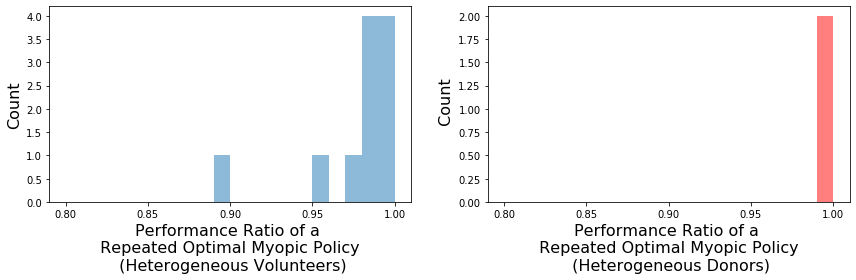

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Set the number of bins
nb = 20
bins = np.arange(nb+1)/nb*.2 + .8

# Plot the histograms in subfigure 1
ax1.hist(incorrects, bins = bins, alpha=0.5, label='Data 1')
ax1.set_xlabel('Performance Ratio of a \n Repeated Optimal Myopic Policy \n (Heterogeneous Volunteers)', fontsize = 16)
ax1.set_ylabel('Count', fontsize = 16)
ax1.set_xlim([0.79, 1.01])
ax1.set_xticks([0.8,0.85,0.9,0.95,1.0])

# Plot the histograms in subfigure 2
ax2.hist(incorrects_dons, bins = bins, color = 'r', alpha=0.5, label='Data 2')
ax2.set_xlabel('Performance Ratio of a \n Repeated Optimal Myopic Policy \n (Heterogeneous Donors)', fontsize = 16)
ax2.set_ylabel('\n Count', fontsize = 16)
ax2.set_xlim([0.79, 1.01])
ax2.set_xticks([0.8,0.85,0.9,0.95,1.0])

# Adjust the spacing between subplots
plt.tight_layout()



# Show the plot
plt.show()